In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
from matplotlib.pyplot import figure

In [5]:
train_X = pd.read_csv('D:/Course content/Minor Project/TDT_Data/After_arima/train_X.csv')
dev_X = pd.read_csv('D:/Course content/Minor Project/TDT_Data/After_arima/dev_X.csv')
test1_X = pd.read_csv('D:/Course content/Minor Project/TDT_Data/After_arima/test1_X.csv')
test2_X = pd.read_csv('D:/Course content/Minor Project/TDT_Data/After_arima/test2_X.csv')
train_Y = pd.read_csv('D:/Course content/Minor Project/TDT_Data/After_arima/train_Y.csv')
dev_Y = pd.read_csv('D:/Course content/Minor Project/TDT_Data/After_arima/dev_Y.csv')
test1_Y = pd.read_csv('D:/Course content/Minor Project/TDT_Data/After_arima/test1_Y.csv')
test2_Y = pd.read_csv('D:/Course content/Minor Project/TDT_Data/After_arima/test2_Y.csv')

train_X = train_X.loc[:, ~train_X.columns.str.contains('^Unnamed')]
dev_X = dev_X.loc[:, ~dev_X.columns.str.contains('^Unnamed')]
test1_X = test1_X.loc[:, ~test1_X.columns.str.contains('^Unnamed')]
test2_X = test2_X.loc[:, ~test2_X.columns.str.contains('^Unnamed')]
train_Y = train_Y.loc[:, ~train_Y.columns.str.contains('^Unnamed')]
dev_Y = dev_Y.loc[:, ~dev_Y.columns.str.contains('^Unnamed')]
test1_Y = test1_Y.loc[:, ~test1_Y.columns.str.contains('^Unnamed')]
test2_Y = test2_Y.loc[:, ~test2_Y.columns.str.contains('^Unnamed')]

# data sampling
STEP = 20
#num_list = [STEP*i for i in range(int(1117500/STEP))]

_train_X = np.asarray(train_X).reshape((int(1117500/STEP), 20, 1))
_dev_X = np.asarray(dev_X).reshape((int(1117500/STEP), 20, 1))
_test1_X = np.asarray(test1_X).reshape((int(1117500/STEP), 20, 1))
_test2_X = np.asarray(test2_X).reshape((int(1117500/STEP), 20, 1))

_train_Y = np.asarray(train_Y).reshape(int(1117500/STEP), 1)
_dev_Y = np.asarray(dev_Y).reshape(int(1117500/STEP), 1)
_test1_Y = np.asarray(test1_Y).reshape(int(1117500/STEP), 1)
_test2_Y = np.asarray(test2_Y).reshape(int(1117500/STEP), 1)

#define custom activation
class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (K.tanh(x) * 2)

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})

# Model Generation
model = Sequential()
#check https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/
model.add(LSTM(25, input_shape=(20,1), dropout=0.0, kernel_regularizer=l1_l2(0.00,0.00), bias_regularizer=l1_l2(0.00,0.00)))
model.add(Dense(1))
model.add(Activation(double_tanh))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
#, kernel_regularizer=l1_l2(0,0.1), bias_regularizer=l1_l2(0,0.1),

print(model.metrics_names)
# Fitting the Model
model_scores = {}
score_list = []
Reg = False
d = 'hybrid_LSTM'

if Reg :
    d += '_with_reg'

epoch_num=1
for _ in range(350):

    # train the model
    
    
    m = model.fit(_train_X, _train_Y, epochs=1, batch_size=500, shuffle=True)
    print('history :', m.history)
    score_list.append(m.history)
    

    # test the model
    score_train = model.evaluate(_train_X, _train_Y)
    score_dev = model.evaluate(_dev_X, _dev_Y)
    score_test1 = model.evaluate(_test1_X, _test1_Y)
    score_test2 = model.evaluate(_test2_X, _test2_Y)
    
    #Prediction Values for train/dev/test1/test2
    
    predTrain = model.predict(np.asarray(_train_X))
    predDev = model.predict(np.asarray(_dev_X))
    predTest1 = model.predict(np.asarray(_test1_X))
    predTest2 = model.predict(np.asarray(_test2_X))

    print('train set score : mse - ' + str(score_train[1]) +' / mae - ' + str(score_train[2]))
    print('dev set score : mse - ' + str(score_dev[1]) +' / mae - ' + str(score_dev[2]))
    print('test1 set score : mse - ' + str(score_test1[1]) +' / mae - ' + str(score_test1[2]))
    print('test2 set score : mse - ' + str(score_test2[1]) +' / mae - ' + str(score_test2[2]))
#.history['mean_squared_error'][0]
    # get former score data
    df = pd.read_csv("D:/Course content/Minor Project/models/hybrid_LSTM2.csv")
    train_mse = list(df['TRAIN_MSE'])
    dev_mse = list(df['DEV_MSE'])
    test1_mse = list(df['TEST1_MSE'])
    test2_mse = list(df['TEST2_MSE'])

    train_mae = list(df['TRAIN_MAE'])
    dev_mae = list(df['DEV_MAE'])
    test1_mae = list(df['TEST1_MAE'])
    test2_mae = list(df['TEST2_MAE'])

    # append new data
    train_mse.append(score_train[1])
    dev_mse.append(score_dev[1])
    test1_mse.append(score_test1[1])
    test2_mse.append(score_test2[1])

    train_mae.append(score_train[2])
    dev_mae.append(score_dev[2])
    test1_mae.append(score_test1[2])
    test2_mae.append(score_test2[2])

    # organize newly created score dataset
    model_scores['TRAIN_MSE'] = train_mse
    model_scores['DEV_MSE'] = dev_mse
    model_scores['TEST1_MSE'] = test1_mse
    model_scores['TEST2_MSE'] = test2_mse

    model_scores['TRAIN_MAE'] = train_mae
    model_scores['DEV_MAE'] = dev_mae
    model_scores['TEST1_MAE'] = test1_mae
    model_scores['TEST2_MAE'] = test2_mae

    # save newly created score dataset
    model_scores_df = pd.DataFrame(model_scores)
    model_scores_df.to_csv("D:/Course content/Minor Project/models/hybrid_LSTM2.csv")

[]
112/112 [==============================] - 1s 11ms/step - loss: 0.0954 - mse: 0.0954 - mae: 0.2394
history : {'loss': [0.09542594105005264], 'mse': [0.09542594105005264], 'mae': [0.23936793208122253]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1146
train set score : mse - 0.02649025246500969 / mae - 0.11260133236646652
dev set score : mse - 0.028483182191848755 / mae - 0.11732513457536697
test1 set score : mse - 0.02833576500415802 / mae - 0.11773449182510376
test2 set score : mse - 0.02768256887793541 / mae - 0.11456424742937088
112/112 [==============================] - 1s 12ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.0844: 0s - loss: 0.0220 - mse: 0.0220 - mae
history : {'loss': [0.02165215276181698], 'mse': [0.02165215276181698], 'mae': [0.08440780639648438]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0211 - mse: 0.0211 - mae: 0.0758
train set score : mse - 0.0196519885212183 / mae - 0.0756306648254394

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0703
train set score : mse - 0.018528632819652557 / mae - 0.0701172947883606
dev set score : mse - 0.020115455612540245 / mae - 0.07225717604160309
test1 set score : mse - 0.019574366509914398 / mae - 0.0728812888264656
test2 set score : mse - 0.02021186798810959 / mae - 0.07025881111621857
112/112 [==============================] - 1s 11ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0718
history : {'loss': [0.018803603947162628], 'mse': [0.018803603947162628], 'mae': [0.07177440077066422]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.0672
train set score : mse - 0.018607979640364647 / mae - 0.06728659570217133
dev set score : mse - 0.020452655851840973 / mae - 0.07076115161180496
test1 set score : mse - 0.019997280091047287 / mae - 0.07174581289291382
test2 set score : mse - 0.020477762445807457 / mae - 0.06716645509004593
112/112 [===========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0756
train set score : mse - 0.018589826300740242 / mae - 0.07614371925592422
dev set score : mse - 0.020213088020682335 / mae - 0.0778941810131073
test1 set score : mse - 0.019996527582406998 / mae - 0.07921750843524933
test2 set score : mse - 0.020199419930577278 / mae - 0.0755869448184967
112/112 [==============================] - 1s 11ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0713
history : {'loss': [0.018513783812522888], 'mse': [0.018513783812522888], 'mae': [0.07129880040884018]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0203 - mse: 0.0203 - mae: 0.0670
train set score : mse - 0.018387526273727417 / mae - 0.06665927916765213
dev set score : mse - 0.020216969773173332 / mae - 0.07012435048818588
test1 set score : mse - 0.01975097879767418 / mae - 0.07098553329706192
test2 set score : mse - 0.020279478281736374 / mae - 0.06698829680681229
112/112 [===========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0198 - mse: 0.0198 - mae: 0.0699
train set score : mse - 0.01816003955900669 / mae - 0.06883753091096878
dev set score : mse - 0.019776061177253723 / mae - 0.07147911936044693
test1 set score : mse - 0.01919618435204029 / mae - 0.07182644307613373
test2 set score : mse - 0.019823428243398666 / mae - 0.06988877803087234
112/112 [==============================] - 1s 10ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.0707
history : {'loss': [0.01828959584236145], 'mse': [0.01828959584236145], 'mae': [0.07065264880657196]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0782
train set score : mse - 0.018952155485749245 / mae - 0.0751814991235733
dev set score : mse - 0.019955554977059364 / mae - 0.07551136612892151
test1 set score : mse - 0.018716759979724884 / mae - 0.07374900579452515
test2 set score : mse - 0.020197581499814987 / mae - 0.07824651896953583
112/112 [=============

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.0740
train set score : mse - 0.018084166571497917 / mae - 0.07339392602443695
dev set score : mse - 0.019683241844177246 / mae - 0.07599619776010513
test1 set score : mse - 0.019261645153164864 / mae - 0.07677694410085678
test2 set score : mse - 0.019525732845067978 / mae - 0.0740368440747261
112/112 [==============================] - 1s 10ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0709
history : {'loss': [0.01817133091390133], 'mse': [0.01817133091390133], 'mae': [0.07094672322273254]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.0714
train set score : mse - 0.018007274717092514 / mae - 0.07038220763206482
dev set score : mse - 0.019634434953331947 / mae - 0.07312092930078506
test1 set score : mse - 0.019101852551102638 / mae - 0.07362530380487442
test2 set score : mse - 0.019580405205488205 / mae - 0.07137322425842285
112/112 [===========

112/112 [==============================] - 1s 11ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.0707
history : {'loss': [0.01801837608218193], 'mse': [0.01801837608218193], 'mae': [0.07073160260915756]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.0725
train set score : mse - 0.017948370426893234 / mae - 0.07221098989248276
dev set score : mse - 0.019666988402605057 / mae - 0.07464022934436798
test1 set score : mse - 0.019419493153691292 / mae - 0.07610999792814255
test2 set score : mse - 0.01956607773900032 / mae - 0.07250412553548813
112/112 [==============================] - 1s 11ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.0703
history : {'loss': [0.017978709191083908], 'mse': [0.017978709191083908], 'mae': [0.07032977044582367]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.0764
train set score : mse - 0.017979037016630173 / mae - 0.07458164542913437
dev set score : mse - 0.0194284953

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0198 - mse: 0.0198 - mae: 0.0727
train set score : mse - 0.017976799979805946 / mae - 0.07209854573011398
dev set score : mse - 0.020021747797727585 / mae - 0.07603783905506134
test1 set score : mse - 0.020206358283758163 / mae - 0.07953240722417831
test2 set score : mse - 0.01982015371322632 / mae - 0.07272841036319733
112/112 [==============================] - 1s 11ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0705
history : {'loss': [0.01776704750955105], 'mse': [0.01776704750955105], 'mae': [0.07048801332712173]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.0702
train set score : mse - 0.017598789185285568 / mae - 0.06823968142271042
dev set score : mse - 0.019252914935350418 / mae - 0.07099618017673492
test1 set score : mse - 0.018578913062810898 / mae - 0.07077055424451828
test2 set score : mse - 0.019171230494976044 / mae - 0.07017560303211212
112/112 [===========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0187 - mse: 0.0187 - mae: 0.0688
train set score : mse - 0.017331846058368683 / mae - 0.06546209007501602
dev set score : mse - 0.018778590485453606 / mae - 0.06806783378124237
test1 set score : mse - 0.017921751365065575 / mae - 0.06761623919010162
test2 set score : mse - 0.018720462918281555 / mae - 0.06877807527780533
112/112 [==============================] - 1s 10ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0693
history : {'loss': [0.01732802577316761], 'mse': [0.01732802577316761], 'mae': [0.06931551545858383]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.0694
train set score : mse - 0.017440874129533768 / mae - 0.06662832945585251
dev set score : mse - 0.019077887758612633 / mae - 0.06940318644046783
test1 set score : mse - 0.01808636263012886 / mae - 0.06817558407783508
test2 set score : mse - 0.018973134458065033 / mae - 0.06939556449651718
112/112 [===========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.0701
train set score : mse - 0.016947302967309952 / mae - 0.06811481714248657
dev set score : mse - 0.01880963146686554 / mae - 0.0715322345495224
test1 set score : mse - 0.018826868385076523 / mae - 0.07415951043367386
test2 set score : mse - 0.01860351487994194 / mae - 0.07006531953811646
112/112 [==============================] - ETA: 0s - loss: 0.0169 - mse: 0.0169 - mae: 0.068 - 1s 11ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0683
history : {'loss': [0.016949526965618134], 'mse': [0.016949526965618134], 'mae': [0.06834506243467331]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0694
train set score : mse - 0.016823455691337585 / mae - 0.06662508100271225
dev set score : mse - 0.01835007034242153 / mae - 0.06918483972549438
test1 set score : mse - 0.01769685186445713 / mae - 0.06917034834623337
test2 set score : mse - 0.01816973648965358

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0189 - mse: 0.0189 - mae: 0.0688
train set score : mse - 0.016860807314515114 / mae - 0.0674315094947815
dev set score : mse - 0.019033566117286682 / mae - 0.07062218338251114
test1 set score : mse - 0.019387220963835716 / mae - 0.07404199987649918
test2 set score : mse - 0.018945740535855293 / mae - 0.06884288042783737
112/112 [==============================] - 1s 11ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0679
history : {'loss': [0.016763776540756226], 'mse': [0.016763776540756226], 'mae': [0.06792519241571426]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0685
train set score : mse - 0.016498178243637085 / mae - 0.06638786941766739
dev set score : mse - 0.018452709540724754 / mae - 0.06957215815782547
test1 set score : mse - 0.018523845821619034 / mae - 0.07188419252634048
test2 set score : mse - 0.018237199634313583 / mae - 0.06851519644260406
112/112 [=========

112/112 [==============================] - 1s 11ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0669
history : {'loss': [0.016445064917206764], 'mse': [0.016445064917206764], 'mae': [0.06685299426317215]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.0678
train set score : mse - 0.016222739592194557 / mae - 0.06478552520275116
dev set score : mse - 0.018035201355814934 / mae - 0.06798545271158218
test1 set score : mse - 0.017934393137693405 / mae - 0.06955347210168839
test2 set score : mse - 0.01792847365140915 / mae - 0.06775569170713425
112/112 [==============================] - 1s 10ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0663
history : {'loss': [0.01635618694126606], 'mse': [0.01635618694126606], 'mae': [0.06630168855190277]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0181 - mse: 0.0181 - mae: 0.0698
train set score : mse - 0.016230067238211632 / mae - 0.0674949362874031
dev set score : mse - 0.01821875385

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0695
train set score : mse - 0.01603766158223152 / mae - 0.06625737994909286
dev set score : mse - 0.01771068014204502 / mae - 0.06892707943916321
test1 set score : mse - 0.01775316148996353 / mae - 0.0711192712187767
test2 set score : mse - 0.017646316438913345 / mae - 0.06950972229242325
112/112 [==============================] - 1s 12ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0662
history : {'loss': [0.016229934990406036], 'mse': [0.016229934990406036], 'mae': [0.06622783839702606]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0664
train set score : mse - 0.01597476191818714 / mae - 0.06343540549278259
dev set score : mse - 0.017856638878583908 / mae - 0.06668689101934433
test1 set score : mse - 0.01778491772711277 / mae - 0.06793320178985596
test2 set score : mse - 0.017831996083259583 / mae - 0.06641169637441635
112/112 [==============

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0698
train set score : mse - 0.01633085124194622 / mae - 0.0669044554233551
dev set score : mse - 0.017936812713742256 / mae - 0.06910199671983719
test1 set score : mse - 0.01751260831952095 / mae - 0.06906499713659286
test2 set score : mse - 0.017786826938390732 / mae - 0.06982715427875519
112/112 [==============================] - 1s 12ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.0653
history : {'loss': [0.01604844443500042], 'mse': [0.01604844443500042], 'mae': [0.0652683824300766]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.0692
train set score : mse - 0.01602260023355484 / mae - 0.06600025296211243
dev set score : mse - 0.018105830997228622 / mae - 0.07009437680244446
test1 set score : mse - 0.018517563119530678 / mae - 0.07314210385084152
test2 set score : mse - 0.017913561314344406 / mae - 0.06920330971479416
112/112 [===============

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0674
train set score : mse - 0.015820616856217384 / mae - 0.06389397382736206
dev set score : mse - 0.01770799420773983 / mae - 0.06721494346857071
test1 set score : mse - 0.017706094309687614 / mae - 0.0686541348695755
test2 set score : mse - 0.017640510573983192 / mae - 0.06743168085813522
112/112 [==============================] - 1s 11ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0648
history : {'loss': [0.015876783058047295], 'mse': [0.015876783058047295], 'mae': [0.06477644294500351]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.0642
train set score : mse - 0.015733210369944572 / mae - 0.06104406714439392
dev set score : mse - 0.017490997910499573 / mae - 0.06418054550886154
test1 set score : mse - 0.017221171408891678 / mae - 0.06507255136966705
test2 set score : mse - 0.017456185072660446 / mae - 0.06419631093740463
112/112 [==========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0655
train set score : mse - 0.01545185036957264 / mae - 0.06252965331077576
dev set score : mse - 0.017162712290883064 / mae - 0.06569496542215347
test1 set score : mse - 0.017091521993279457 / mae - 0.06665481626987457
test2 set score : mse - 0.017045263200998306 / mae - 0.06551267206668854
112/112 [==============================] - 1s 11ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0639
history : {'loss': [0.01566486619412899], 'mse': [0.01566486619412899], 'mae': [0.06392575800418854]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0658
train set score : mse - 0.015567581169307232 / mae - 0.06269916892051697
dev set score : mse - 0.017241554334759712 / mae - 0.06578812003135681
test1 set score : mse - 0.01716475561261177 / mae - 0.06683684885501862
test2 set score : mse - 0.01711617223918438 / mae - 0.06578577309846878
112/112 [=============

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0691
train set score : mse - 0.015551416203379631 / mae - 0.0663616880774498
dev set score : mse - 0.016944993287324905 / mae - 0.06869026273488998
test1 set score : mse - 0.01652393862605095 / mae - 0.06834160536527634
test2 set score : mse - 0.01676221378147602 / mae - 0.0690762996673584
112/112 [==============================] - 1s 11ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0639
history : {'loss': [0.015531448647379875], 'mse': [0.015531448647379875], 'mae': [0.06394194066524506]}
1747/1747 [==============================] - 3s 1ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0689
train set score : mse - 0.015378949232399464 / mae - 0.0650312751531601
dev set score : mse - 0.01689702644944191 / mae - 0.06795032322406769
test1 set score : mse - 0.017018811777234077 / mae - 0.06955751776695251
test2 set score : mse - 0.016931692138314247 / mae - 0.06893991678953171
112/112 [==============

112/112 [==============================] - 1s 11ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0632
history : {'loss': [0.015279695391654968], 'mse': [0.015279695391654968], 'mae': [0.0631835088133812]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0166 - mse: 0.0166 - mae: 0.0640
train set score : mse - 0.015097077935934067 / mae - 0.06052067503333092
dev set score : mse - 0.01673222705721855 / mae - 0.0637732744216919
test1 set score : mse - 0.0165359228849411 / mae - 0.06458040326833725
test2 set score : mse - 0.0166205745190382 / mae - 0.06398557126522064
112/112 [==============================] - 1s 11ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0635
history : {'loss': [0.015304524451494217], 'mse': [0.015304524451494217], 'mae': [0.0635274350643158]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0617
train set score : mse - 0.015267026610672474 / mae - 0.05799243599176407
dev set score : mse - 0.016969127580523

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0657
train set score : mse - 0.014888250268995762 / mae - 0.06246214732527733
dev set score : mse - 0.016627153381705284 / mae - 0.06596582382917404
test1 set score : mse - 0.01657586731016636 / mae - 0.06693810969591141
test2 set score : mse - 0.016498742625117302 / mae - 0.06570512801408768
112/112 [==============================] - 1s 11ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0624
history : {'loss': [0.014995884150266647], 'mse': [0.014995884150266647], 'mae': [0.06236008182168007]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0662
train set score : mse - 0.014978551305830479 / mae - 0.0634852945804596
dev set score : mse - 0.016579052433371544 / mae - 0.06644442677497864
test1 set score : mse - 0.016357457265257835 / mae - 0.06636887043714523
test2 set score : mse - 0.016388999298214912 / mae - 0.06616999953985214
112/112 [==========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0671
train set score : mse - 0.014719812199473381 / mae - 0.0639108344912529
dev set score : mse - 0.016456132754683495 / mae - 0.06732430309057236
test1 set score : mse - 0.016399221494793892 / mae - 0.06814324855804443
test2 set score : mse - 0.016226928681135178 / mae - 0.06711319088935852
112/112 [==============================] - 1s 11ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0624
history : {'loss': [0.014909781515598297], 'mse': [0.014909781515598297], 'mae': [0.06243491172790527]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0629
train set score : mse - 0.015311875380575657 / mae - 0.05918107554316521
dev set score : mse - 0.01671472005546093 / mae - 0.06224924325942993
test1 set score : mse - 0.015991052612662315 / mae - 0.0618794746696949
test2 set score : mse - 0.01649073325097561 / mae - 0.06292308866977692
112/112 [============

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0670
train set score : mse - 0.014624960720539093 / mae - 0.06358807533979416
dev set score : mse - 0.01636764220893383 / mae - 0.06728848814964294
test1 set score : mse - 0.01649201288819313 / mae - 0.06823650002479553
test2 set score : mse - 0.016146989539265633 / mae - 0.06697854399681091
112/112 [==============================] - 1s 11ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0612
history : {'loss': [0.014612538740038872], 'mse': [0.014612538740038872], 'mae': [0.06123606115579605]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0674
train set score : mse - 0.014612111262977123 / mae - 0.06371379643678665
dev set score : mse - 0.01602051593363285 / mae - 0.0663575530052185
test1 set score : mse - 0.015589476563036442 / mae - 0.06627088785171509
test2 set score : mse - 0.01590113341808319 / mae - 0.06736811250448227
112/112 [=============

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0648
train set score : mse - 0.014379039406776428 / mae - 0.06235645338892937
dev set score : mse - 0.01625804230570793 / mae - 0.06527339667081833
test1 set score : mse - 0.01661173440515995 / mae - 0.06738107651472092
test2 set score : mse - 0.01608699932694435 / mae - 0.0647868812084198
112/112 [==============================] - 1s 12ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0610
history : {'loss': [0.014419634826481342], 'mse': [0.014419634826481342], 'mae': [0.06101146712899208]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0688
train set score : mse - 0.014734995551407337 / mae - 0.06771769374608994
dev set score : mse - 0.016564175486564636 / mae - 0.06949527561664581
test1 set score : mse - 0.01730950176715851 / mae - 0.07313219457864761
test2 set score : mse - 0.01625492051243782 / mae - 0.06880276650190353
112/112 [==============

train set score : mse - 0.014146977104246616 / mae - 0.06204848363995552
dev set score : mse - 0.01585051231086254 / mae - 0.06475909799337387
test1 set score : mse - 0.01603006199002266 / mae - 0.06697354465723038
test2 set score : mse - 0.015729142352938652 / mae - 0.0648573637008667
112/112 [==============================] - 1s 13ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0612
history : {'loss': [0.014321192167699337], 'mse': [0.014321192167699337], 'mae': [0.06116211414337158]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0595
train set score : mse - 0.014377453364431858 / mae - 0.05620532110333443
dev set score : mse - 0.01630340702831745 / mae - 0.059285566210746765
test1 set score : mse - 0.01615314371883869 / mae - 0.0605161190032959
test2 set score : mse - 0.0163270290941 / mae - 0.05951933562755585
112/112 [==============================] - 1s 11ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0606
history : {'loss': [0.014242

112/112 [==============================] - 1s 11ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0602
history : {'loss': [0.014045222662389278], 'mse': [0.014045222662389278], 'mae': [0.06022513657808304]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0652
train set score : mse - 0.014374876394867897 / mae - 0.06366663426160812
dev set score : mse - 0.016719145700335503 / mae - 0.0665603056550026
test1 set score : mse - 0.017847727984189987 / mae - 0.0710008442401886
test2 set score : mse - 0.016352737322449684 / mae - 0.06515055149793625
112/112 [==============================] - 1s 11ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0609
history : {'loss': [0.014142770320177078], 'mse': [0.014142770320177078], 'mae': [0.060898344963788986]}
1747/1747 [==============================] - 3s 1ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0599
train set score : mse - 0.014015765860676765 / mae - 0.05722175911068916
dev set score : mse - 0.01603426

1747/1747 [==============================] - 3s 1ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0654
train set score : mse - 0.013943327590823174 / mae - 0.062051549553871155
dev set score : mse - 0.015780432149767876 / mae - 0.06495234370231628
test1 set score : mse - 0.01583399996161461 / mae - 0.06569458544254303
test2 set score : mse - 0.015674108639359474 / mae - 0.06536263972520828
112/112 [==============================] - 1s 11ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0611
history : {'loss': [0.01407499611377716], 'mse': [0.01407499611377716], 'mae': [0.06110179424285889]}
1747/1747 [==============================] - 3s 1ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0636
train set score : mse - 0.01389690674841404 / mae - 0.06142362207174301
dev set score : mse - 0.015558449551463127 / mae - 0.06330915540456772
test1 set score : mse - 0.015456204302608967 / mae - 0.06434942781925201
test2 set score : mse - 0.015438229776918888 / mae - 0.06361669301986694
112/112 [===========

1747/1747 [==============================] - 3s 1ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0677
train set score : mse - 0.013940107077360153 / mae - 0.06468450278043747
dev set score : mse - 0.015738997608423233 / mae - 0.06716708838939667
test1 set score : mse - 0.015602304600179195 / mae - 0.06710748374462128
test2 set score : mse - 0.01551798079162836 / mae - 0.06765854358673096
112/112 [==============================] - 1s 11ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0599
history : {'loss': [0.01385530922561884], 'mse': [0.01385530922561884], 'mae': [0.05994300916790962]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0600
train set score : mse - 0.013710950501263142 / mae - 0.05717768520116806
dev set score : mse - 0.015686610713601112 / mae - 0.06003238260746002
test1 set score : mse - 0.015595920383930206 / mae - 0.061390478163957596
test2 set score : mse - 0.01552905235439539 / mae - 0.06004859134554863
112/112 [===========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0638
train set score : mse - 0.013686665333807468 / mae - 0.06057975813746452
dev set score : mse - 0.015942761674523354 / mae - 0.06375713646411896
test1 set score : mse - 0.016882706433534622 / mae - 0.06745995581150055
test2 set score : mse - 0.015798982232809067 / mae - 0.0637701004743576
112/112 [==============================] - 1s 11ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0594
history : {'loss': [0.013704062439501286], 'mse': [0.013704061508178711], 'mae': [0.05944380909204483]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0632
train set score : mse - 0.013517405837774277 / mae - 0.06027991697192192
dev set score : mse - 0.015543144196271896 / mae - 0.0630674958229065
test1 set score : mse - 0.015913425013422966 / mae - 0.06488709151744843
test2 set score : mse - 0.015307430177927017 / mae - 0.06315106898546219
112/112 [==========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0633
train set score : mse - 0.013630153611302376 / mae - 0.060175538063049316
dev set score : mse - 0.015681248158216476 / mae - 0.06346942484378815
test1 set score : mse - 0.015536179766058922 / mae - 0.06325284391641617
test2 set score : mse - 0.015422746539115906 / mae - 0.0633382722735405
112/112 [==============================] - 1s 11ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0596
history : {'loss': [0.01365200337022543], 'mse': [0.01365200337022543], 'mae': [0.05962168425321579]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0620
train set score : mse - 0.01338066253811121 / mae - 0.05847219377756119
dev set score : mse - 0.01541116926819086 / mae - 0.06137674301862717
test1 set score : mse - 0.015864474698901176 / mae - 0.06385979801416397
test2 set score : mse - 0.015355291776359081 / mae - 0.061953768134117126
112/112 [===========

112/112 [==============================] - 1s 12ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0600
history : {'loss': [0.013612659648060799], 'mse': [0.013612659648060799], 'mae': [0.05998225510120392]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0613
train set score : mse - 0.013332263566553593 / mae - 0.05895325541496277
dev set score : mse - 0.01540667749941349 / mae - 0.06195111572742462
test1 set score : mse - 0.015796847641468048 / mae - 0.06346927583217621
test2 set score : mse - 0.015198417007923126 / mae - 0.06125720217823982
112/112 [==============================] - 1s 11ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0598
history : {'loss': [0.013561032712459564], 'mse': [0.013561032712459564], 'mae': [0.05975031480193138]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0644
train set score : mse - 0.013668273575603962 / mae - 0.061117757111787796
dev set score : mse - 0.0155170

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0705
train set score : mse - 0.014112327247858047 / mae - 0.0687493160367012
dev set score : mse - 0.015960566699504852 / mae - 0.07032915949821472
test1 set score : mse - 0.016903357580304146 / mae - 0.07363635301589966
test2 set score : mse - 0.015817169100046158 / mae - 0.07052603363990784
112/112 [==============================] - 1s 11ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0597
history : {'loss': [0.013481316156685352], 'mse': [0.013481316156685352], 'mae': [0.05966321751475334]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0619
train set score : mse - 0.013341818004846573 / mae - 0.05783938243985176
dev set score : mse - 0.015156392939388752 / mae - 0.060624755918979645
test1 set score : mse - 0.01529186312109232 / mae - 0.0629647895693779
test2 set score : mse - 0.015212604776024818 / mae - 0.061894431710243225
112/112 [=========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0619
train set score : mse - 0.013141610659658909 / mae - 0.05920553207397461
dev set score : mse - 0.015300712548196316 / mae - 0.06223466247320175
test1 set score : mse - 0.01609640382230282 / mae - 0.06474991887807846
test2 set score : mse - 0.015096564777195454 / mae - 0.06194770708680153
112/112 [==============================] - 1s 11ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0583
history : {'loss': [0.013288246467709541], 'mse': [0.013288246467709541], 'mae': [0.05826091766357422]}
1747/1747 [==============================] - 3s 1ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0626
train set score : mse - 0.013356679119169712 / mae - 0.05907132476568222
dev set score : mse - 0.015118790790438652 / mae - 0.06186956539750099
test1 set score : mse - 0.014989187009632587 / mae - 0.062254827469587326
test2 set score : mse - 0.015145679004490376 / mae - 0.0625782310962677
112/112 [=========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0593
train set score : mse - 0.013294107280671597 / mae - 0.056092116981744766
dev set score : mse - 0.01503855362534523 / mae - 0.05868544802069664
test1 set score : mse - 0.014561505056917667 / mae - 0.058517731726169586
test2 set score : mse - 0.014895042404532433 / mae - 0.05934855341911316
112/112 [==============================] - 1s 11ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0584
history : {'loss': [0.013325865380465984], 'mse': [0.013325865380465984], 'mae': [0.058449551463127136]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0712
train set score : mse - 0.013861448504030704 / mae - 0.06817331165075302
dev set score : mse - 0.01587006077170372 / mae - 0.07119017839431763
test1 set score : mse - 0.01692279241979122 / mae - 0.07432643324136734
test2 set score : mse - 0.015623271465301514 / mae - 0.07118162512779236
112/112 [========

1747/1747 [==============================] - 3s 1ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0592
train set score : mse - 0.013052262365818024 / mae - 0.055307090282440186
dev set score : mse - 0.014984391629695892 / mae - 0.058122050017118454
test1 set score : mse - 0.015048300847411156 / mae - 0.058978114277124405
test2 set score : mse - 0.015029393136501312 / mae - 0.05915834382176399
112/112 [==============================] - 1s 11ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0580
history : {'loss': [0.013110503554344177], 'mse': [0.013110503554344177], 'mae': [0.058030322194099426]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0626
train set score : mse - 0.013053826056420803 / mae - 0.05813399329781532
dev set score : mse - 0.01473755668848753 / mae - 0.06075652316212654
test1 set score : mse - 0.014529679901897907 / mae - 0.06117112934589386
test2 set score : mse - 0.014775731600821018 / mae - 0.06258200109004974
112/112 [=====

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0602
train set score : mse - 0.01292603462934494 / mae - 0.05686129629611969
dev set score : mse - 0.015290831215679646 / mae - 0.06070437282323837
test1 set score : mse - 0.015787778422236443 / mae - 0.06320971250534058
test2 set score : mse - 0.015139284543693066 / mae - 0.06018085777759552
112/112 [==============================] - 1s 11ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0578
history : {'loss': [0.013034411706030369], 'mse': [0.013034411706030369], 'mae': [0.05783931538462639]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0681
train set score : mse - 0.013478933833539486 / mae - 0.06289271265268326
dev set score : mse - 0.014961604960262775 / mae - 0.06566155701875687
test1 set score : mse - 0.014352095313370228 / mae - 0.06409113109111786
test2 set score : mse - 0.01514376513659954 / mae - 0.06813164055347443
112/112 [==========

112/112 [==============================] - 1s 11ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0577
history : {'loss': [0.01300463080406189], 'mse': [0.01300462894141674], 'mae': [0.05770023167133331]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0625
train set score : mse - 0.013221575878560543 / mae - 0.058667559176683426
dev set score : mse - 0.015781220048666 / mae - 0.06256276369094849
test1 set score : mse - 0.017465395852923393 / mae - 0.06782667338848114
test2 set score : mse - 0.015909655019640923 / mae - 0.06251206994056702
112/112 [==============================] - 1s 11ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0589
history : {'loss': [0.013136760331690311], 'mse': [0.013136760331690311], 'mae': [0.05889683961868286]}
1747/1747 [==============================] - 3s 1ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0605
train set score : mse - 0.012720810249447823 / mae - 0.057391755282878876
dev set score : mse - 0.0148477749

1747/1747 [==============================] - 3s 1ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0601
train set score : mse - 0.012651591561734676 / mae - 0.05702267587184906
dev set score : mse - 0.014637134969234467 / mae - 0.05992737039923668
test1 set score : mse - 0.014843196608126163 / mae - 0.06124669313430786
test2 set score : mse - 0.01456011738628149 / mae - 0.060141194611787796
112/112 [==============================] - 1s 11ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0577
history : {'loss': [0.012921104207634926], 'mse': [0.012921104207634926], 'mae': [0.057729966938495636]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0591
train set score : mse - 0.012831839732825756 / mae - 0.05550573393702507
dev set score : mse - 0.014953050762414932 / mae - 0.05896085500717163
test1 set score : mse - 0.015221945941448212 / mae - 0.06062457710504532
test2 set score : mse - 0.014977577142417431 / mae - 0.05908513441681862
112/112 [=======

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0589
train set score : mse - 0.012657633982598782 / mae - 0.054645806550979614
dev set score : mse - 0.014998000115156174 / mae - 0.05852755531668663
test1 set score : mse - 0.01570935919880867 / mae - 0.0611443966627121
test2 set score : mse - 0.015064694918692112 / mae - 0.058945510536432266
112/112 [==============================] - 1s 11ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0574
history : {'loss': [0.012881350703537464], 'mse': [0.012881350703537464], 'mae': [0.0574316643178463]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0641
train set score : mse - 0.012852792628109455 / mae - 0.059874724596738815
dev set score : mse - 0.014981260523200035 / mae - 0.06391152739524841
test1 set score : mse - 0.01584247499704361 / mae - 0.06706360727548599
test2 set score : mse - 0.014956798404455185 / mae - 0.06405886262655258
112/112 [=========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0582
train set score : mse - 0.012581582181155682 / mae - 0.05447976663708687
dev set score : mse - 0.014569410122931004 / mae - 0.057841818779706955
test1 set score : mse - 0.014459342695772648 / mae - 0.058302268385887146
test2 set score : mse - 0.014509439468383789 / mae - 0.05824235454201698
112/112 [==============================] - 1s 11ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0570: 0s - loss: 0.0128 - mse: 0.0128 - mae: 0.0
history : {'loss': [0.012783331796526909], 'mse': [0.012783331796526909], 'mae': [0.057044267654418945]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0571
train set score : mse - 0.012821472249925137 / mae - 0.052623212337493896
dev set score : mse - 0.015164684504270554 / mae - 0.05663382634520531
test1 set score : mse - 0.015273974277079105 / mae - 0.05793936550617218
test2 set score : mse - 0.0151938321068882

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0601
train set score : mse - 0.012417693622410297 / mae - 0.056496553122997284
dev set score : mse - 0.014558007940649986 / mae - 0.0599776990711689
test1 set score : mse - 0.014992138370871544 / mae - 0.06135588511824608
test2 set score : mse - 0.014473168179392815 / mae - 0.06007956713438034
112/112 [==============================] - 1s 11ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0570
history : {'loss': [0.012673459015786648], 'mse': [0.012673459015786648], 'mae': [0.05699757859110832]}
1747/1747 [==============================] - 2s 1ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0607
train set score : mse - 0.012491903267800808 / mae - 0.05676767975091934
dev set score : mse - 0.014847739599645138 / mae - 0.06072958931326866
test1 set score : mse - 0.015505722723901272 / mae - 0.06325067579746246
test2 set score : mse - 0.01474599726498127 / mae - 0.06069246307015419
112/112 [=========

1747/1747 [==============================] - 2s 1ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0579
train set score : mse - 0.012480105273425579 / mae - 0.05406372621655464
dev set score : mse - 0.015173593536019325 / mae - 0.05862494930624962
test1 set score : mse - 0.01620161347091198 / mae - 0.06182621046900749
test2 set score : mse - 0.015009259805083275 / mae - 0.05788185074925423
112/112 [==============================] - 1s 11ms/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0569
history : {'loss': [0.012624390423297882], 'mse': [0.012624390423297882], 'mae': [0.056936342269182205]}
1747/1747 [==============================] - 3s 1ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0580
train set score : mse - 0.012470666319131851 / mae - 0.054003678262233734
dev set score : mse - 0.01454912405461073 / mae - 0.05701928585767746
test1 set score : mse - 0.01459537073969841 / mae - 0.058066364377737045
test2 set score : mse - 0.01462921965867281 / mae - 0.05800457298755646


In [4]:
import csv
with open('D:/Course content/Minor Project/models/hybrid_LSTM2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["TRAIN_MSE", "DEV_MSE", "TEST1_MSE", "TEST2_MSE", "TRAIN_MAE","DEV_MAE", "TEST1_MAE", "TEST2_MAE"])

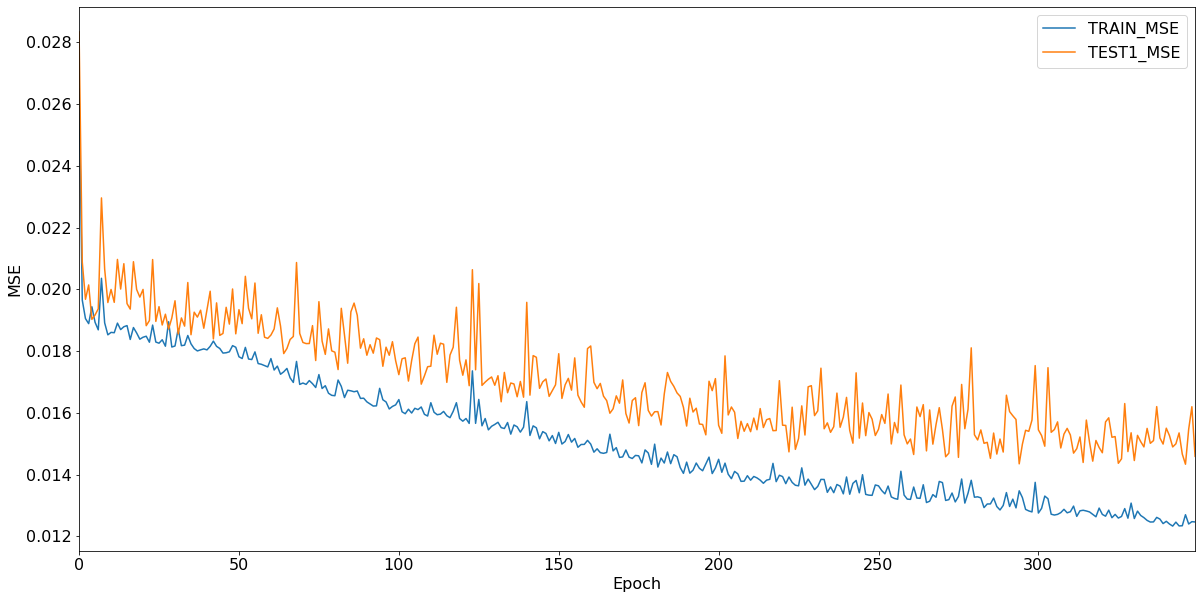

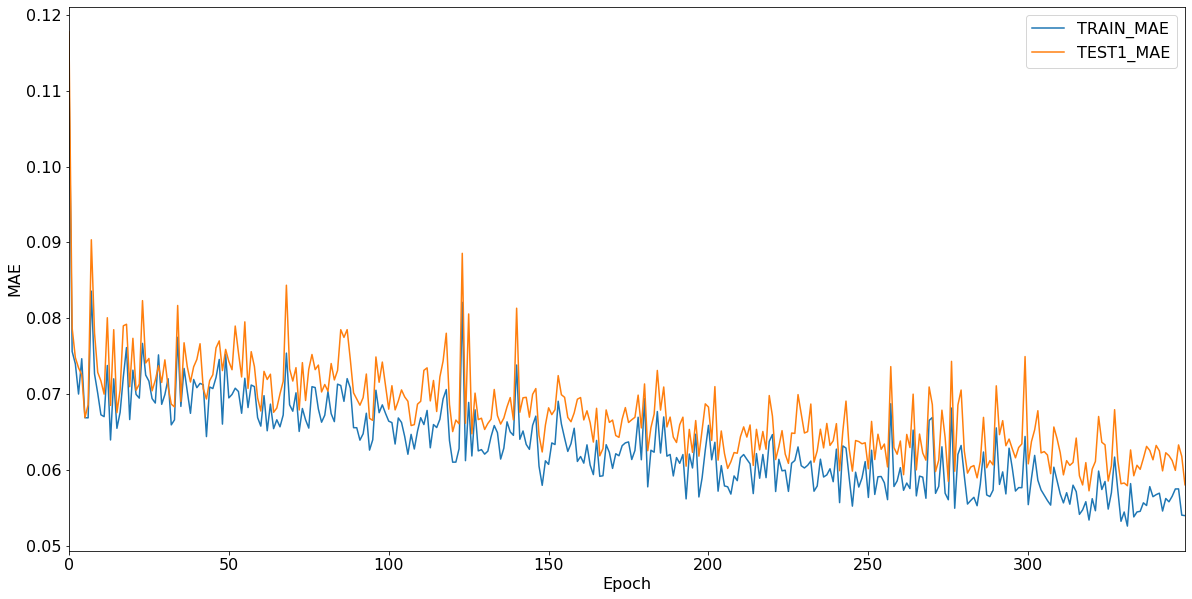

In [6]:
result = pd.read_csv("D:/Course content/Minor Project/models/hybrid_LSTM2.csv")
columns = list(result)
ylabels = ["MSE", "MAE"]
i = 1
j = 0
while i < 8:
    result.plot(x=columns[0], y=[columns[i], columns[i+2]], kind="line", figsize=(20,10))
    plt.xlabel("Epoch")
    plt.ylabel(ylabels[j])
    plt.show()
    i += 4
    j += 1

In [7]:
from matplotlib.pyplot import figure

<Figure size 1200x800 with 0 Axes>

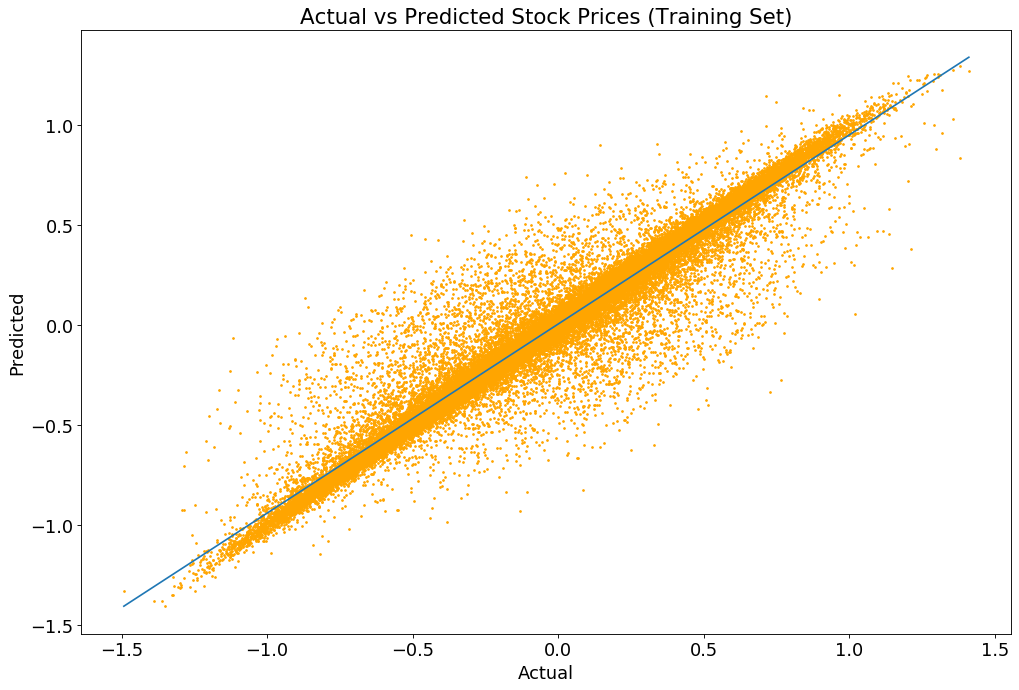

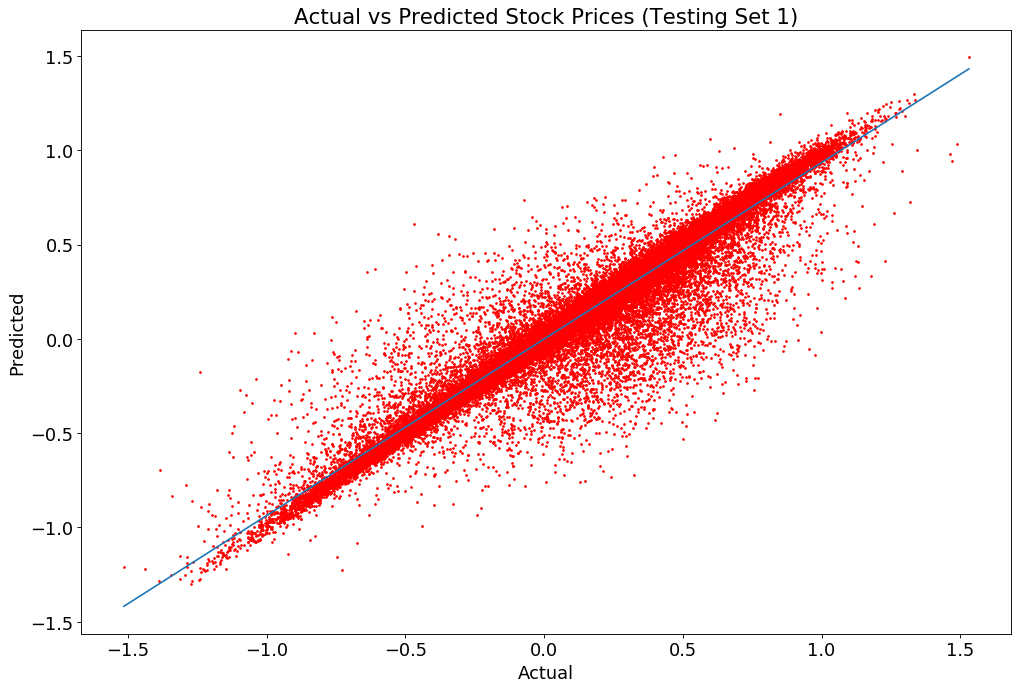

In [8]:
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
p1 = predTrain.flatten() 
p2 = predDev.flatten()
p3 = predTest1.flatten() 
p4 = predTest2.flatten()

e1 = _train_Y.flatten()
e2 = _dev_Y.flatten()
e3 = _test1_Y.flatten()
e4 = _test2_Y.flatten()

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(e1, p1, color = "orange", s=2)
plt.title("Actual vs Predicted Stock Prices (Training Set)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.unique(e1), np.poly1d(np.polyfit(e1, p1, 1))(np.unique(e1)))
plt.show()

# figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(e2, p2, color = "salmon", s=2)
# plt.title("Actual vs Predicted Stock Prices (Development Set)")
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.plot(np.unique(e2), np.poly1d(np.polyfit(e2, p2, 1))(np.unique(e2)))
# plt.show()

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(e3, p3, color = "red", s=2)
plt.title("Actual vs Predicted Stock Prices (Testing Set 1)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.unique(e3), np.poly1d(np.polyfit(e3, p3, 1))(np.unique(e3)))
plt.show()

# figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(e4, p4, color = "coral", s=2)
# plt.title("Actual vs Predicted Stock Prices (Testing Set 2)")
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.plot(np.unique(e4), np.poly1d(np.polyfit(e4, p4, 1))(np.unique(e4)))
# plt.show()